In [1]:
import zipfile
import os
from ultralytics import YOLO
import cv2
import pytesseract
import re
import torch
import matplotlib.pyplot as plt  # Correct import as plt

In [129]:
print(f"MPS available: {torch.backends.mps.is_available()}")
# Output: MPS available: True

MPS available: True


In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
# Output: Using device: mps

Using device: mps


In [131]:
#model.save("fine_tuned.pt")
model = YOLO("fine_tuned_cool.pt")

In [132]:
def expand_bbox_for_label_search(bbox, img_width, img_height, expand_pixels=500):
    x1, y1, x2, y2 = bbox
    
    # Expand left (reduce x1) and down (increase y2)
    x1 = max(0, x1 - expand_pixels)              # Ensure x1 doesn't go below 0
    x2 = min(img_width, x2 + int(expand_pixels/2))
    return (x1, y1, x2, y2)

def infer_field_purpose(text):
    patterns = {
        "email": r"\b(email|e-mail)\b",
        "phone": r"\b(phone|mobile|tel)\b",
        "name": r"\b(name|full name)\b",
        "date": r"\b(date|dob)\b"
    }
    for key, pattern in patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            return key
    return "unknown"

def is_checkbox_checked(checkbox_img):
    gray = cv2.cvtColor(checkbox_img, cv2.COLOR_BGR2GRAY)
    mean_brightness = gray.mean()
    return mean_brightness < 50  # Threshold for checked state


image 1/1 /Users/user/venv/Yadro_dataset_generator/doc_parts/jpg_docs/document_158.jpeg: 1280x992 2 input_fields, 1 checkbox, 103.0ms
Speed: 289.4ms preprocess, 103.0ms inference, 102.6ms postprocess per image at shape (1, 3, 1280, 992)


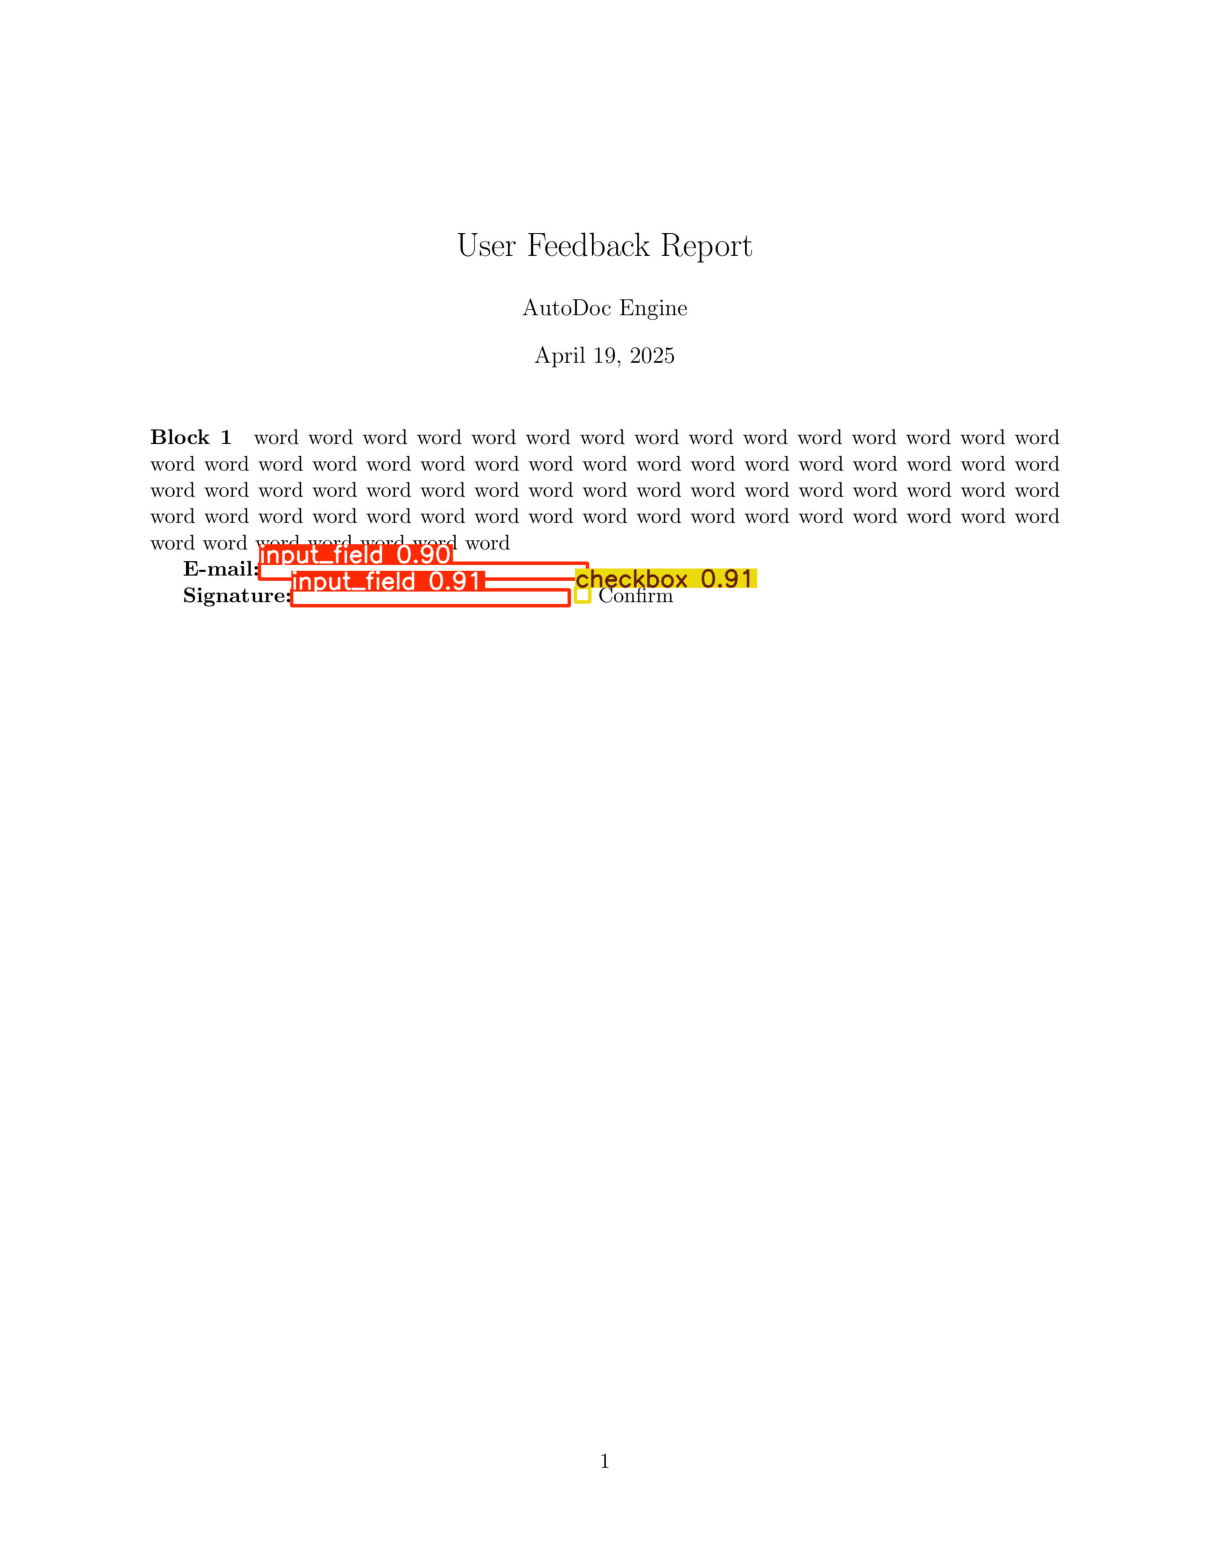

In [138]:
img_path="doc_parts/jpg_docs/document_158.jpeg"

# Run inference
results_f = model.predict(
    source=img_path,
    conf=0.7,
    batch=16,
    imgsz=1280,
    save=False,
    device = device # Disable saving
)
annotated_img = results_f[0].plot(
    labels=True, 
    conf=True,    
    line_width=5,  # Thinner bounding boxes (optional)
    font_size=10  # Smaller font (if any text remains)
)

# Display
plt.figure(figsize=(20, 20))
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

In [139]:
image = cv2.imread(img_path)
output_fields = []

for box in results_f[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = model.names[int(box.cls)]
    
    # Expand region to capture nearby labels
    expanded_bbox = expand_bbox_for_label_search((x1, y1, x2, y2), image.shape[1], image.shape[0])
    x1_exp, y1_exp, x2_exp, y2_exp = expanded_bbox
    expanded_region = image[y1_exp:y2_exp, x1_exp:x2_exp]
    
    # OCR on expanded region
    text = pytesseract.image_to_string(expanded_region)
    text = " ".join(text.split())  # Clean whitespace
    
    # Determine required and purpose
    is_required = "*" in text or "required" in text.lower()
    purpose = infer_field_purpose(text)

    base_info = {
            "type": cls,
            "coordinates": (x1, y1, x2, y2),
            "label": text,
            "required": is_required,
            "purpose": purpose
        }
    
    # For checkboxes, add state
    if cls == "checkbox":
        checkbox_img = image[y1:y2, x1:x2]
        state = "checked" if is_checkbox_checked(checkbox_img) else "unchecked"
        output_fields.append({**base_info, "state": state})
    else:
        output_fields.append({**base_info})

print(output_fields)

[{'type': 'input_field', 'coordinates': (603, 1242, 1198, 1276), 'label': 'slenature: LI Connrm', 'required': False, 'purpose': 'unknown'}, {'type': 'checkbox', 'coordinates': (1211, 1237, 1242, 1268), 'label': 'Confirm', 'required': False, 'purpose': 'unknown', 'state': 'unchecked'}, {'type': 'input_field', 'coordinates': (534, 1185, 1237, 1219), 'label': 'H-mMmall:', 'required': False, 'purpose': 'unknown'}]


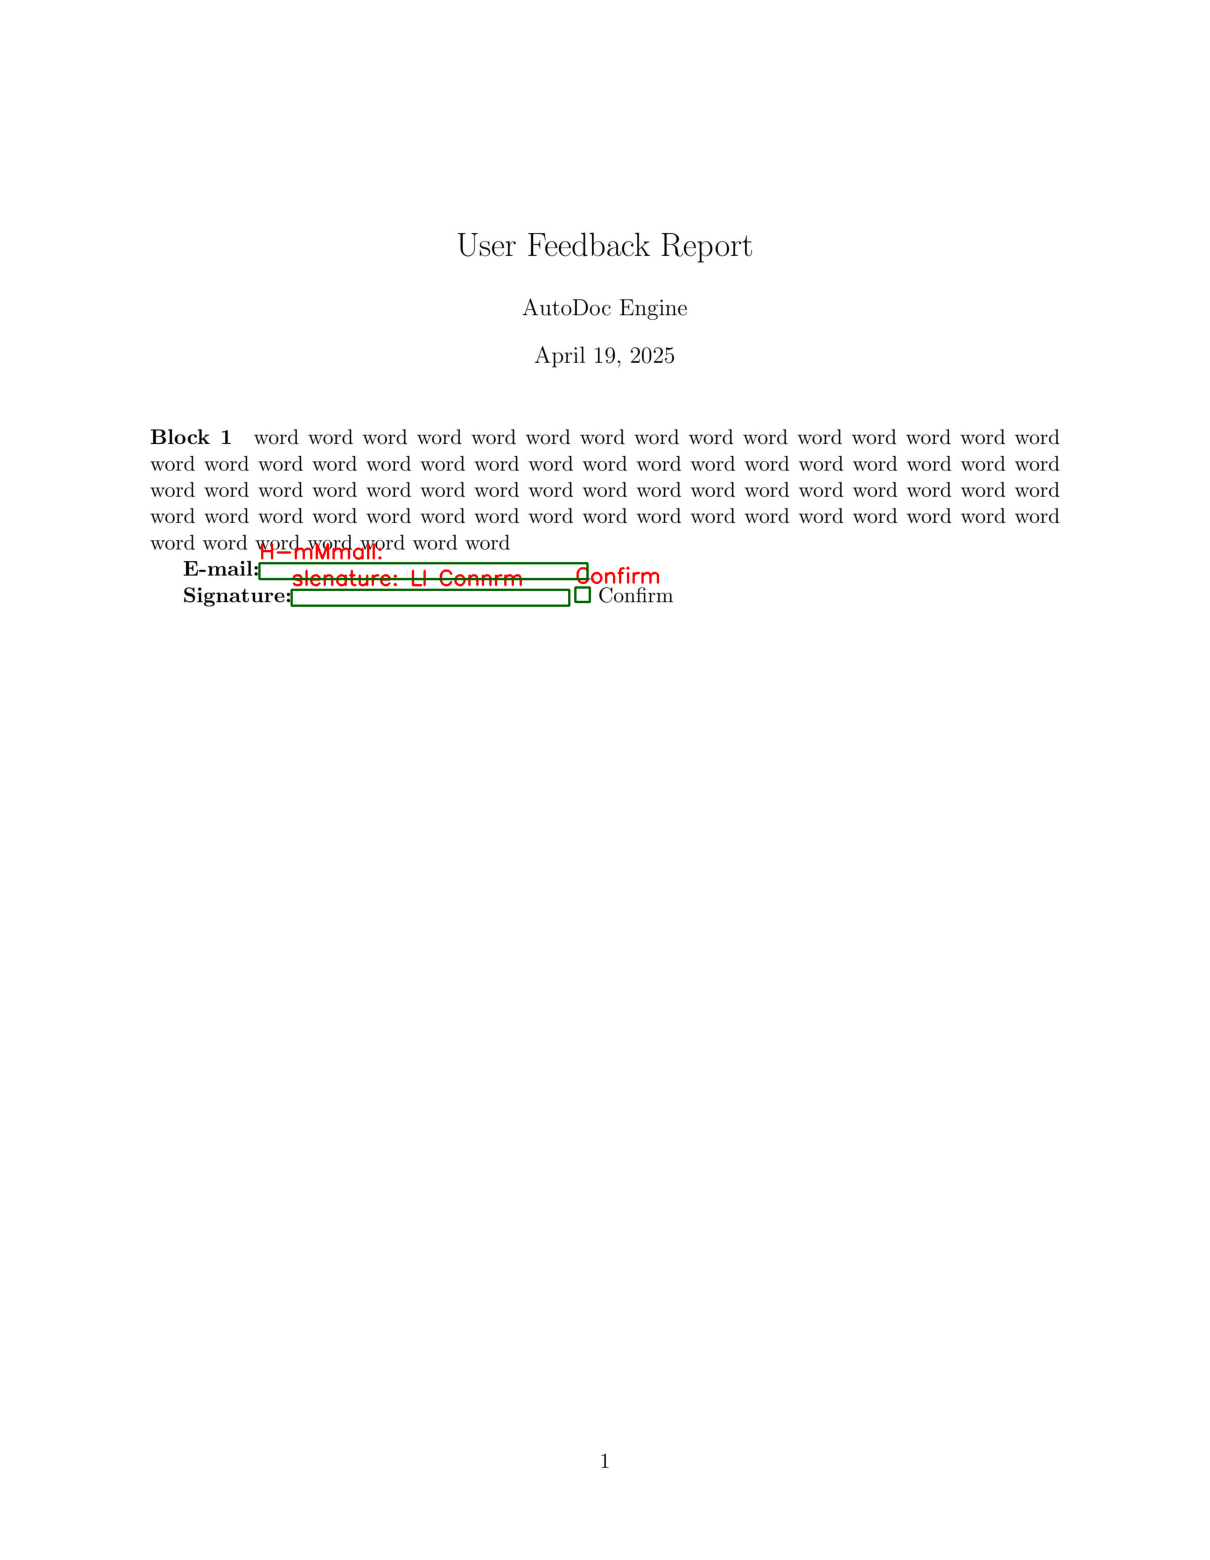

In [140]:
box_color = (0, 100, 0)  # Green (RGB)
text_color = (255, 0, 0)  # Red (RGB)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.5
thickness = 3

for entry in output_fields:
    x1, y1, x2, y2 = entry['coordinates']
    label = entry['label']
    
    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), box_color, thickness)
    
    # Add label text (above the box)
    text_position = (x1, y1 - 10)  # Adjust position as needed
    cv2.putText(image, label, text_position, font, font_scale, text_color, thickness)

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [141]:
def extract_text_blocks(image_region):
    """Extract OCR data with word-level bounding boxes."""
    return pytesseract.image_to_data(
        image_region, 
        output_type=pytesseract.Output.DICT,
        config='--psm 6'  # Sparse text layout
    )

def find_main_label(ocr_data, input_bbox):
    """Find the label closest to the input field/checkbox."""
    input_x1, input_y1, input_x2, input_y2 = input_bbox
    main_label = ""
    min_distance = float('inf')
    
    for i in range(len(ocr_data['text'])):
        text = ocr_data['text'][i].strip()
        if not text:
            continue
        
        # Get word coordinates
        x1 = ocr_data['left'][i]
        y1 = ocr_data['top'][i]
        x2 = x1 + ocr_data['width'][i]
        y2 = y1 + ocr_data['height'][i]
        
        # Prioritize labels to the left/above the input field
        distance = abs(x2 - input_x1) + abs(y1 - input_y1)  # Manhattan distance
        
        if distance < min_distance:
            min_distance = distance
            main_label = text
    
    return main_label

def clean_text(text):
    """Remove noise from OCR text."""
    text = ''.join(c for c in text if c.isalnum() or c in [' ', ':']).strip()
    words = [word for word in text.split() if len(word) > 2]  # Filter short words
    return ' '.join(words)

In [142]:
image = cv2.imread(img_path)
output_fields = []

for box in results_f[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = model.names[int(box.cls)]
    
    # Expand region to capture nearby labels
    expanded_bbox = expand_bbox_for_label_search((x1, y1, x2, y2), image.shape[1], image.shape[0])
    x1_exp, y1_exp, x2_exp, y2_exp = expanded_bbox
    expanded_region = image[y1_exp:y2_exp, x1_exp:x2_exp]
    
    # Get OCR data and find the most relevant label
    ocr_data = extract_text_blocks(expanded_region)
    raw_label = find_main_label(ocr_data, (x1, y1, x2, y2))
    cleaned_label = clean_text(raw_label)
    
    # Determine required status and purpose
    is_required = "*" in cleaned_label or "required" in cleaned_label.lower()
    purpose = infer_field_purpose(cleaned_label)

    base_info = {
        "type": cls,
        "coordinates": (x1, y1, x2, y2),
        "label": cleaned_label,  # Use cleaned label instead of raw OCR text
        "required": is_required,
        "purpose": purpose
    }
    
    # For checkboxes, add state
    if cls == "checkbox":
        checkbox_img = image[y1:y2, x1:x2]
        state = "checked" if is_checkbox_checked(checkbox_img) else "unchecked"
        output_fields.append({**base_info, "state": state})
    else:
        output_fields.append(base_info)

print(output_fields)

[{'type': 'input_field', 'coordinates': (603, 1242, 1198, 1276), 'label': 'slenature:', 'required': False, 'purpose': 'unknown'}, {'type': 'checkbox', 'coordinates': (1211, 1237, 1242, 1268), 'label': 'Confirm', 'required': False, 'purpose': 'unknown', 'state': 'unchecked'}, {'type': 'input_field', 'coordinates': (534, 1185, 1237, 1219), 'label': 'HmMmall:', 'required': False, 'purpose': 'unknown'}]


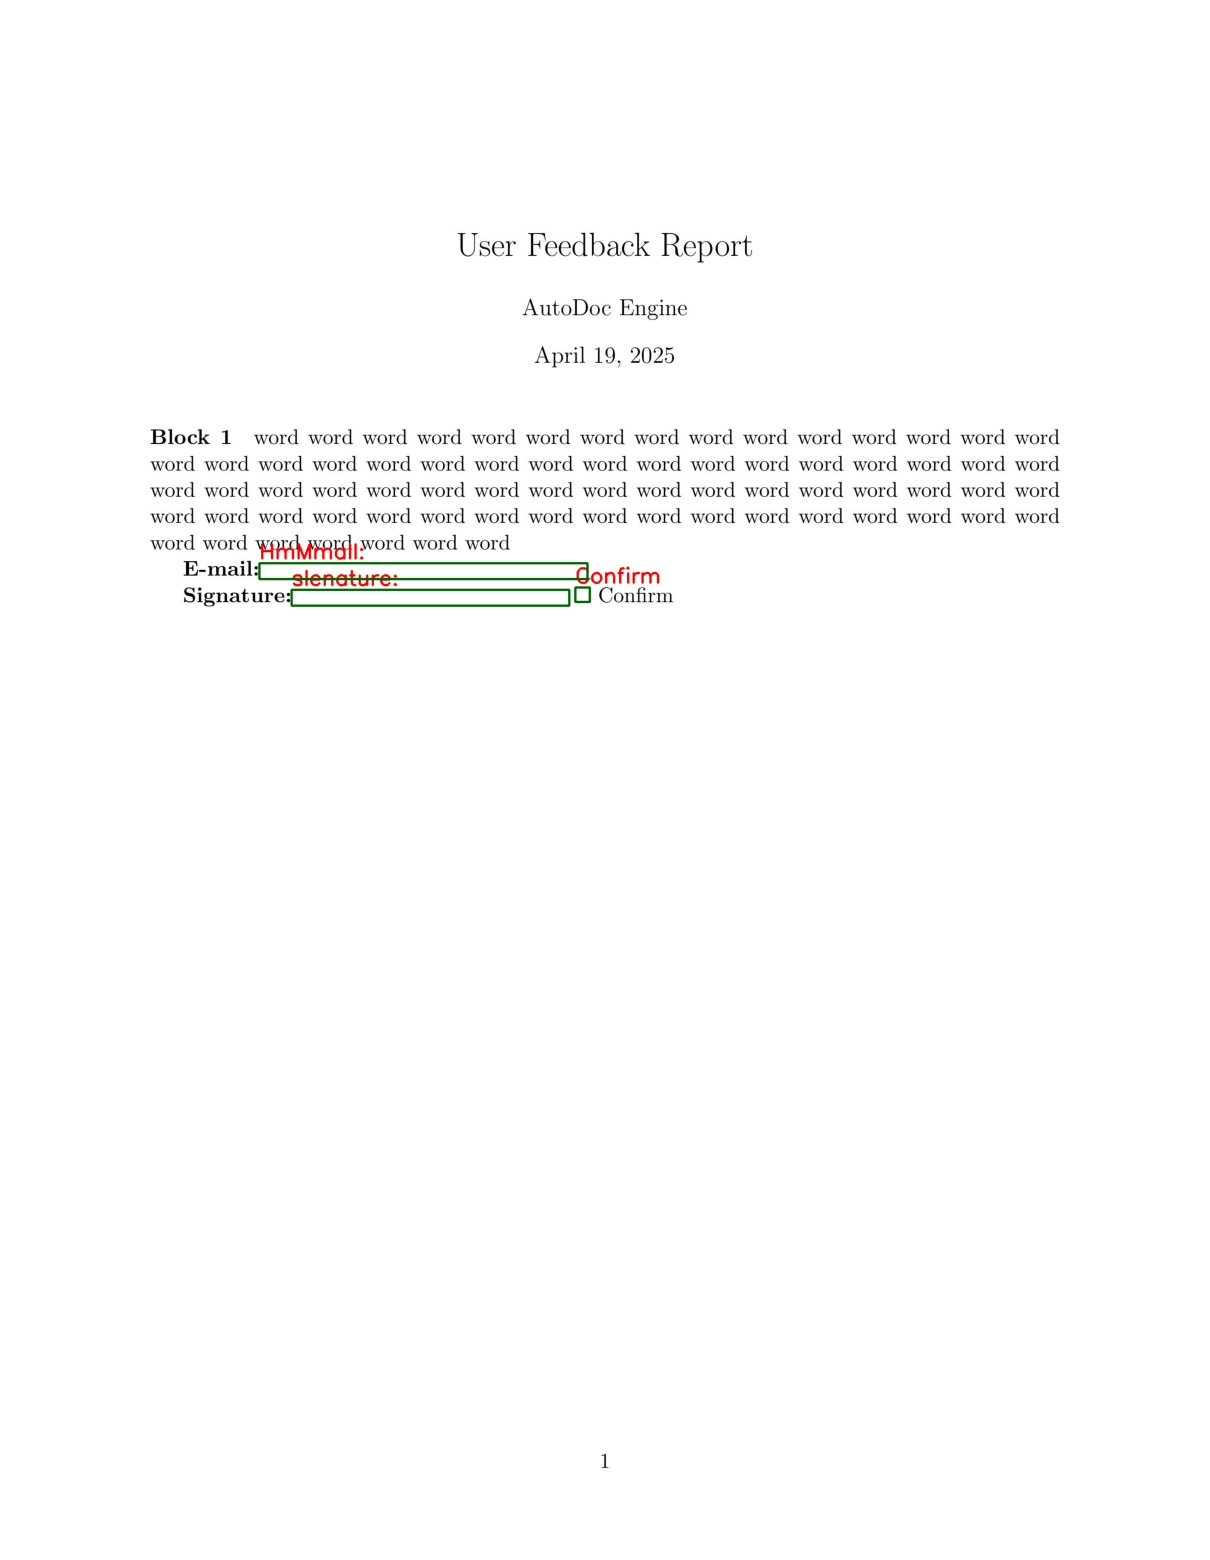

In [143]:
box_color = (0, 100, 0)  # Green (RGB)
text_color = (255, 0, 0)  # Red (RGB)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.5
thickness = 3

for entry in output_fields:
    x1, y1, x2, y2 = entry['coordinates']
    label = entry['label']
    
    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), box_color, thickness)
    
    # Add label text (above the box)
    text_position = (x1, y1 - 10)  # Adjust position as needed
    cv2.putText(image, label, text_position, font, font_scale, text_color, thickness)

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()